In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from sklearn.neighbors import KDTree
import shapely
from core.cluster_validation import generate_detailed_clusters
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import cluster_data

CPU times: user 11.5 s, sys: 418 ms, total: 11.9 s
Wall time: 9.56 s


In [2]:
tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'

In [3]:
# 107131 - krakow
# 86873 = vienna
# 69333 = prague
# 4 - rhineruhr
# 55763 - berlin
#bratislava - 99886
# freiburg - 5883
 # hamburg - 16242


region_id = 69333
# val_path = '/data/uscuni-ulce/validation/val_morphotopes/prague_morphotopes.pq'

In [4]:
# region_id = 4

In [5]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}.parquet")
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)
# morphotopes = gpd.read_parquet(val_path)

In [6]:
X_train

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,likWCe,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo
-4118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389672,26.102067,24.709464,0.0,0.330128,4.0,0.259887,0.999442,0.280867,5.010847,0.007752,...,0.000217,1.0,28.604379,25.337530,0.295454,1.006141,0.347775,10.233447,1.128933,1.128933
389673,14.280497,15.353218,0.0,0.588388,4.0,1.100546,0.997959,0.719019,2.754933,0.025876,...,0.000171,1.0,15.847184,15.981284,0.730930,1.008640,0.608395,5.758885,0.991609,0.991609
389674,71.484873,36.150692,0.0,0.491669,4.0,0.918899,1.000160,0.477450,6.777067,0.047100,...,0.000420,1.0,75.131307,36.778758,0.485820,1.004782,0.501898,13.805685,2.042791,2.042791
389675,104.745679,42.442747,0.0,0.553525,4.0,0.023191,1.000031,0.582264,7.759757,0.001366,...,0.000213,1.0,109.021319,43.070813,0.588401,1.003982,0.561565,15.722113,2.531211,2.531211


In [7]:


# tess_groups = generate_detailed_clusters(tessellation,
#                                          include_random_sample=False, path=val_path)
# tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]


# tess_groups_ilocs = (
#     pd.Series(np.arange(len(X_train[X_train.index >=0])), index=X_train[X_train.index >=0].index)
#     .loc[tess_groups.index]
#     .values
# )

In [8]:
# spatial_lags = [1, 2, 3, 4, 5]
# kernels = ['gaussian', 'inverse', 'weights']
# lag_types = ['_median', '_iqr', '_']
# cluster_sizes = [50, 75, 100, 150, 250]
# chars_to_drop = [
#     [],
#     ['stcSAl', 'stcOri'],
#     [
#        'stcSAl',
#        'ltkOri',
#          'stbOri',
#          'stcOri',
#          'stbCeA'
#     ]
          
# ]
# clips = [None, (-5,5), (-10, 10)]


# linkage = 'ward'
# metric = 'euclidean'
# centroids = shapely.get_coordinates(tessellation.representative_point())

In [9]:
from core.generate_context import partial_weighted_percentile

In [10]:
from core.generate_clusters import preprocess_clustering_data, get_clusters, post_process_clusters_tightening, get_tree
# # label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [11]:
## should reflect src/core/clustering
min_cluster_size = 100

spatial_lag = 0
kernel=None
lag_type = None

clip = None
to_drop = ['stcSAl','stbOri','stcOri','stbCeA', 
           'ldkAre', 'ldkPer', 'lskCCo', 'lskERI',
           'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe']

linkage='ward'
metric='euclidean'
eom_clusters = False


In [12]:
%%time

if lag_type is not None:
    centroids = shapely.get_coordinates(tessellation.representative_point())
    lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10, bandwidth=-1)
    lag = lag[[c for c in lag.columns if lag_type in c]]
    clustering_data = X_train.join(lag, how='inner')
else:
    clustering_data = X_train

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.53 μs


In [13]:
clustering_data.shape

(393795, 72)

In [14]:
to_drop2 = clustering_data.columns[clustering_data.columns.str[3:] == 'Are']
to_drop2

Index(['sdbAre', 'ldsAre', 'sddAre', 'midAre', 'sdcAre', 'mdcAre', 'ldkAre',
       'sdsAre', 'mibAre'],
      dtype='object')

In [15]:
# to_drop = np.union1d(to_drop2, to_drop).tolist()

In [16]:
def cluster_data(X_train, graph, to_drop, clip, min_cluster_size, linkage, metric, eom_clusters=True):
    '''Split the input data into connected components and carry out an agglomerative clustering for each component independently.
    Pre-process the input data, cluster and then carry out post-processing and finally combine all the seperate clusterings into one set of clusters.'''
    
    # label building input data, could work with empty tess as well
    building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
    labels = building_graph.component_labels
    
    results = {}
    
    for label, group in labels.groupby(labels):
    
        if group.shape[0] <= min_cluster_size:
            component_clusters = np.full(group.shape[0], -1)
    
        else:
            component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values], clip=clip, to_drop=to_drop)
            component_graph = building_graph.subgraph(group.index.values)
            ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)
    
            # # sometimes ward linkage breaks the monotonic increase in the MST
            # # if that happens shift all distances by the max drop
            # # need a loop because several connections might be problematic
            problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
            while problem_idxs.shape[0]:
                ward_tree[problem_idxs + 1, 2] = ward_tree[problem_idxs, 2] + .01
                problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
            # check if ward tree distances are always increasing
            assert (ward_tree[1:, 2] >= ward_tree[0:-1, 2]).all()
            
            component_clusters = get_clusters(ward_tree, min_cluster_size, component_buildings_data.shape[0], eom_clusters=eom_clusters)
                
           ## post process
            res = component_buildings_data.groupby(component_clusters).apply(post_process_clusters_tightening, min_cluster_size=min_cluster_size, t=7)
            if res.shape[0] == 1:
                component_clusters = pd.Series(res.values[0], res.columns)
            else:
                component_clusters = pd.Series(res.values, res.index.get_level_values(1)).loc[component_buildings_data.index].values
            
            # for c in np.unique(component_clusters):
            #     # if c == -1: continue
            #     cluster_graph = component_graph.subgraph(group.index[component_clusters == c].values)
            #     assert cluster_graph.n_components == 1
        
        results[label] = component_clusters

    ### relabel local clusters(0,1,2,0,1) to regional clusters(0_0,0_1,0_2, 0_0,0_1,) etc
    label_groups = labels.groupby(labels)
    region_cluster_labels = []
    for label, component_clusters in results.items():
        group = label_groups.get_group(label)
        component_labels = str(label) + '_' + pd.Series(component_clusters.astype(str), 
                                                        index=group.index.values)
        region_cluster_labels.append(component_labels)
    
    region_cluster_labels = pd.concat(region_cluster_labels).sort_index()
    assert (X_train[X_train.index >= 0].index == region_cluster_labels.index).all()
    
    return region_cluster_labels

In [17]:
%%time
region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)

CPU times: user 45.6 s, sys: 355 ms, total: 45.9 s
Wall time: 45.8 s


In [18]:
labels.value_counts()

component labels
850     86500
130     20622
192     16077
62       5624
76       5524
        ...  
3534        1
3533        1
3529        1
3524        1
3545        1
Name: count, Length: 3559, dtype: int64

In [19]:
label = 849
labels.groupby(labels).get_group(label).shape

(36,)

In [20]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [21]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [22]:
## there is some issue here with the subsetting

In [23]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
# plotting['label'] = region_cluster_labels[region_cluster_labels.str.startswith(str(label))].values
plotting['label'] = region_cluster_labels.loc[labels.groupby(labels).get_group(label).index.values].values
# plotting['label'] = plotting['label']
plotting['label'] = plotting['label'].str.split('_').str[1].astype(int)
plotting.shape

(36, 4)

In [42]:
plotting['label'].nunique()

505

In [43]:
layer.get_fill_color = get_color(plotting['label'].values)

In [44]:
plotting['label'].value_counts()

label
-1      16404
 323      960
 109      668
 348      632
 193      628
        ...  
 199      101
 142      101
 102      101
 325      101
 405      100
Name: count, Length: 505, dtype: int64

In [28]:
plotting['index']

0          63190
1          63192
2          63194
3          63195
4          63197
           ...  
114231    447720
114232    447721
114233    447722
114234    447724
114235    447725
Name: index, Length: 114236, dtype: int64

In [29]:
# buildings = gpd.read_parquet(buildings_dir + 'buildings_freiburg.parquet')
# plotting = buildings

In [30]:
%%time
import lonboard
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.03 s, sys: 168 ms, total: 2.2 s
Wall time: 2.2 s


In [31]:
from sidecar import Sidecar
sc = Sidecar(title='Morphotopes')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [ ]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
morph_clrs_geometry = clrs_geometry.set_geometry('geometry').reset_index()

In [33]:
morph_clrs_geometry.to_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [33]:
# gpd.read_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq').explore()

----

In [24]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [25]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [26]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [27]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [28]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 30 s, sys: 2.88 ms, total: 30 s
Wall time: 30 s


In [29]:
# component_data[('Size', 'Size')] = X_train.loc[region_cluster_labels.index].groupby(region_cluster_labels.values).size()
# component_data.to_parquet(f'../data/morphotopes_data_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [30]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

In [31]:

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [32]:
# component_data = component_data.clip(-10, 10)

In [33]:
# component_data = component_data[component_data.columns[component_data.columns.get_level_values(1).str.contains('median')]]

In [34]:
# dists, component_data.iloc[idxs[0]].index

In [35]:
# from sklearn.neighbors import KDTree
# tree = KDTree(component_data.values)
# dists, idxs = tree.query(component_data.loc[['3_6']].values, k=10)

# morph_clrs_geometry.set_index('label').loc[component_data.iloc[idxs[0]].index].explore(column=dists[0], )

In [36]:
X_train.loc[region_cluster_labels.index].groupby(region_cluster_labels.values).size()

0_-1         1
1000_-1     57
1001_-1     83
1002_-1      8
1003_-1      2
          ... 
997_-1       1
998_-1     115
999_-1       1
99_-1        1
9_-1       156
Length: 4589, dtype: int64

In [49]:
umap_metric ='euclidean'
n_neighbors = 10

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc 

<Axes: >

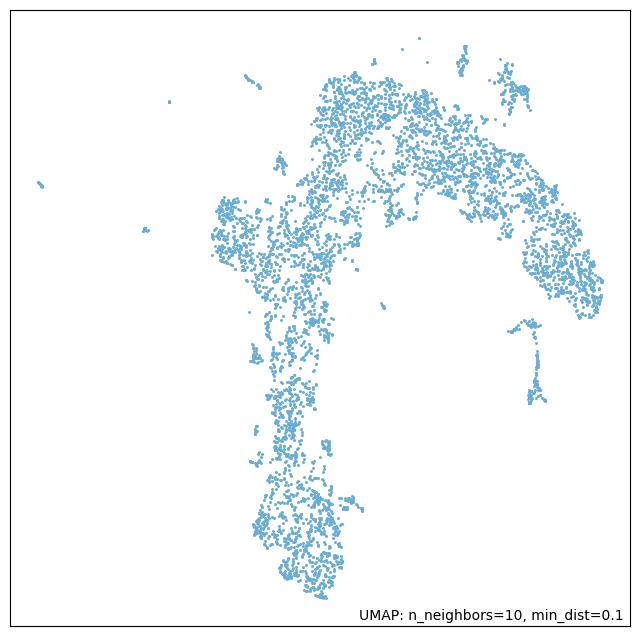

In [50]:
import umap
import umap.plot
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, 
                    negative_sample_rate=50, min_dist=0.1, metric=umap_metric, verbose=False, random_state=1)
emb = reducer.fit_transform(component_data)
umap.plot.points(reducer)

In [51]:
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)
embedding = reducer.fit_transform(component_data)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=10, negative_sample_rate=50, random_state=1, verbose=True)
Thu Oct 17 13:45:21 2024 Construct fuzzy simplicial set
Thu Oct 17 13:45:21 2024 Finding Nearest Neighbors
Thu Oct 17 13:45:21 2024 Building RP forest with 9 trees
Thu Oct 17 13:45:21 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Thu Oct 17 13:45:21 2024 Finished Nearest Neighbor Search
Thu Oct 17 13:45:21 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct 17 13:46:08 2024 Finished embedding


In [37]:
# tr_data = embedding
tr_data = component_data

In [38]:
final_linkage = 'ward'
final_metric = 'euclidean'

In [39]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    metric=final_metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(tr_data)
linkage_matrix = get_linkage_matrix(model)

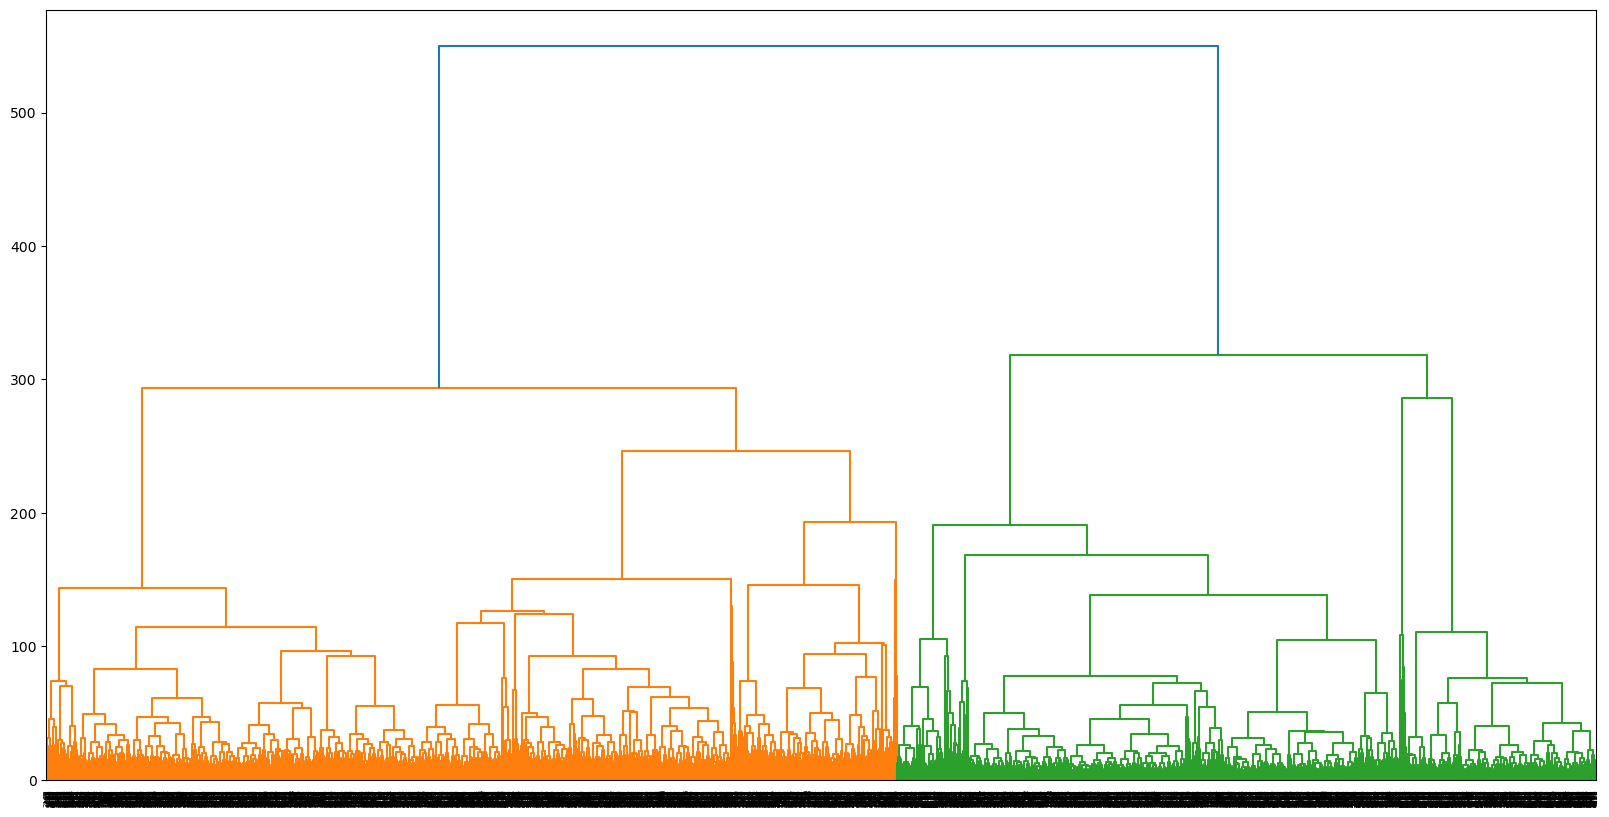

In [40]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [41]:
cutoff = 200

In [42]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
np.unique(clusters)

array([1, 2, 3, 4, 5, 6], dtype=int32)

In [43]:
# gpd.read_parquet('../data/clusters_umap_freiburg_100_3_gaussian_euclidean_complete_chebyshev_5.pq').explore()

In [44]:


# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=15, max_iter=5000, n_init=300, random_state=1).fit(tr_data).labels_
# np.unique(clusters)

In [45]:

# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=n_neighbors)
# clusterer.fit(component_data)
# clusters = clusterer.labels_
# np.unique(clusters)

In [46]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [47]:
# layer.get_fill_color = get_color(clusters)

In [48]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [49]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
# layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 6.04 s, sys: 428 ms, total: 6.46 s
Wall time: 6.46 s


In [50]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [51]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [284]:
# gpd.read_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq').explore()

In [285]:
fbc = gpd.read_parquet('../data/freiburg/freiburg_building_census.pq')

In [52]:
clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = clusters
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')
clrs_geometry = clrs_geometry.reset_index()

NameError: name 'clusters' is not defined

In [287]:
# Overlay cells with clusters to get intersections
overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')

# Calculate the area of overlap
overlap['area'] = overlap.geometry.area

# Find the cluster with the largest overlap for each cell
largest_overlap = overlap.loc[overlap.groupby(overlap['ID'])['area'].idxmax()]

/tmp/ipykernel_589934/715595176.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')


In [288]:
cols = largest_overlap.columns[largest_overlap.columns.str.contains('19') | largest_overlap.columns.str.contains('19')].sort_values()
age_cols = [cols[-1]] + list(cols[:-1])
age_cols

res = largest_overlap.iloc[:, 2:].dissolve('label', aggfunc='sum')
res[age_cols]

,Before 1919,1919 - 1948,1949 - 1978,1979 - 1986,1987 - 1990,1991 - 1995,1996 - 2000
label,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,535.0,118.0,359.0,69.0,6.0,19.0,18.0
4,1385.0,406.0,704.0,74.0,23.0,18.0,21.0
5,179.0,889.0,1000.0,174.0,34.0,21.0,43.0
6,200.0,151.0,402.0,13.0,10.0,18.0,135.0
7,81.0,319.0,1074.0,186.0,40.0,33.0,55.0
8,41.0,100.0,648.0,77.0,19.0,30.0,40.0
9,0.0,0.0,106.0,27.0,16.0,6.0,86.0


In [289]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[ind], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.347
  Kappa:    0.268



In [290]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[age_cols], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.231
  Kappa:    0.125



In [291]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False).iloc[:10]


1949 - 1978    0.320713
Before 1919    0.245733
1919 - 1948    0.212132
1979 - 1986    0.104255
1996 - 2000    0.065185
1991 - 1995    0.027025
1987 - 1990    0.024956
dtype: float64

In [127]:
clrs_geometry.to_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq')

In [128]:
component_data.to_parquet(f'../data/morphotopes_data_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [ ]:
# gkf = model_selection.StratifiedGroupKFold(n_splits=5)
# splits = gkf.split(
#     largest_overlap[ind],
#     largest_overlap["label"].astype(str),
#     groups=largest_overlap["label"],
# )

In [ ]:
# split_label = np.empty(len(largest_overlap), dtype=float)
# for i, (train, test) in enumerate(splits):
#     split_label[test] = i
# largest_overlap["split"] = split_label

In [ ]:
# ax = largest_overlap.plot(
#   "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
# )
# largest_overlap.dissolve("label").convex_hull.boundary.plot(
#     ax=ax, color="k", linewidth=0.5, markersize=0
# )
# ax.set_axis_off()

In [ ]:
from libpysal import graph
import esda


In [ ]:
col = '1979 - 1986'

In [ ]:
contiguity = graph.Graph.build_contiguity(fbc, rook=False)
contiguity_r = contiguity.transform("r")
lisa = esda.Moran_Local(fbc[col].fillna(0), contiguity_r)

In [ ]:
# lisa.explore(
# fbc,
# crit_value=0.05,
#   prefer_canvas=True,
#   tiles="CartoDB Positron",
# )

---

### bandwidth stuff

In [11]:
from scipy.optimize import minimize, least_squares, root_scalar, brentq
from numba import njit
from scipy.fftpack import fft

@njit(cache=True)
def histogram(data, bins, range_hist=None):
    """Jitted histogram.

    Parameters
    ----------
    data : array-like
        Input data. Passed as first positional argument to ``np.histogram``.
    bins : int or array-like
        Passed as keyword argument ``bins`` to ``np.histogram``.
    range_hist : (float, float), optional
        Passed as keyword argument ``range`` to ``np.histogram``.

    Returns
    -------
    hist : array
        The number of counts per bin.
    density : array
        The density corresponding to each bin.
    bin_edges : array
        The edges of the bins used.
    """
    hist, bin_edges = np.histogram(data, bins=bins, range=range_hist)
    hist_dens = hist / (hist.sum() * np.diff(bin_edges))
    return hist, hist_dens, bin_edges


def _root(n_p, k_sq, a_sq, x):
    def _fixed_point(t_s, x_len, k_sq, a_sq):
        """Calculate t-zeta*gamma^[l](t).

        Implementation of the function t-zeta*gamma^[l](t) derived from equation (30) in [1].

        References
        ----------
        .. [1] Kernel density estimation via diffusion.
        Z. I. Botev, J. F. Grotowski, and D. P. Kroese.
        Ann. Statist. 38 (2010), no. 5, 2916--2957.
        """
        k_sq = np.asarray(k_sq, dtype=np.float64)
        a_sq = np.asarray(a_sq, dtype=np.float64)

        k_o = 7
        func = np.sum(np.power(k_sq, k_o) * a_sq * np.exp(-k_sq * np.pi**2 * t_s))
        func *= 0.5 * np.pi ** (2.0 * k_o)

        for ite in np.arange(k_o - 1, 2 - 1, -1):
            c_1 = (1 + 0.5 ** (ite + 0.5)) / 3
            c_2 = np.prod(np.arange(1.0, 2 * ite + 1, 2, dtype=np.float64))
            c_2 /= (np.pi / 2) ** 0.5
            t_j = np.power((c_1 * (c_2 / (x_len * func))), (2.0 / (3.0 + 2.0 * ite)))
            func = np.sum(k_sq**ite * a_sq * np.exp(-k_sq * np.pi**2.0 * t_j))
            func *= 0.5 * np.pi ** (2 * ite)

        out = t_s - (2 * x_len * np.pi**0.5 * func) ** (-0.4)
        return out

    # The right bound is at most 0.01
    found = False
    n_p = max(min(1050, n_p), 50)
    tol = 10e-12 + 0.01 * (n_p - 50) / 1000

    while not found:
        try:
            band_w, res = brentq(
                _fixed_point, 0, 0.01, args=(n_p, k_sq, a_sq), full_output=True, disp=False
            )
            found = res.converged
        except ValueError:
            band_w = 0
            tol *= 2.0
            found = False
        if band_w <= 0 or tol >= 1:
            band_w = (_bw_silverman(x) / np.ptp(x)) ** 2
            return band_w
    return band_w

def _dct1d(x):
    """Discrete Cosine Transform in 1 Dimension.

    Parameters
    ----------
    x : numpy array
        1 dimensional array of values for which the
        DCT is desired

    Returns
    -------
    output : DTC transformed values
    """
    x_len = len(x)

    even_increasing = np.arange(0, x_len, 2)
    odd_decreasing = np.arange(x_len - 1, 0, -2)

    x = np.concatenate((x[even_increasing], x[odd_decreasing]))

    w_1k = np.r_[1, (2 * np.exp(-(0 + 1j) * (np.arange(1, x_len)) * np.pi / (2 * x_len)))]
    output = np.real(w_1k * fft(x))

    return output


def _bw_isj(x, grid_counts=None, x_range=None):
    """Improved Sheather-Jones bandwidth estimation.

    Improved Sheather and Jones method as explained in [1]_. This method is used internally by the
    KDE estimator, resulting in saved computation time as minimums, maximums and the grid are
    pre-computed.

    References
    ----------
    .. [1] Kernel density estimation via diffusion.
       Z. I. Botev, J. F. Grotowski, and D. P. Kroese.
       Ann. Statist. 38 (2010), no. 5, 2916--2957.
    """
    x_len = len(x)
    grid_len = len(grid_counts) - 1
    # Discrete cosine transform of the data
    a_k = _dct1d(grid_counts / x_len)

    k_sq = np.arange(1, grid_len) ** 2
    a_sq = a_k[range(1, grid_len)] ** 2
    return _root(x_len, k_sq, a_sq, x) ** 0.5 * x_range




def kde(x):
    x = x[np.isfinite(x)]
    if x.size == 0 or np.all(x == x[0]):
        warnings.warn("Your data appears to have a single value or no finite values")

        return np.zeros(2), np.array([np.nan] * 2)

    grid_len = 256
    # Preliminary calculations
    x_min = x.min()
    x_max = x.max()
    x_range = x_max - x_min

    # Determine grid
    grid_min = x_min
    grid_max = x_max

    grid_counts, _, grid_edges = histogram(x, grid_len, (grid_min, grid_max))

    # Bandwidth estimation

    band_w = _bw_isj(x, grid_counts=grid_counts, x_range=x_range)
    return band_w

In [12]:
## distances
from sklearn.neighbors import KDTree

tree = KDTree(centroids)
dist, ind = tree.query(centroids, k=8)
dist = dist[:, 1:].ravel()
dist.sort()
kde(dist)

np.float64(4.765916614570653)

In [13]:
### hdbscan bandwith

In [14]:
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
    CondensedTree,
    bfs_from_hierarchy,
    eliminate_branch
)

In [15]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [16]:
kernel = 'gaussian'
spatial_lag = 3
lag_type = '_median'

In [63]:
%%time

X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')


lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)
lag = lag[[c for c in lag.columns if lag_type in c]]
clustering_data = X_train.join(lag, how='inner')

X_train = clustering_data
X_train.shape

CPU times: user 4min 14s, sys: 21.7 s, total: 4min 36s
Wall time: 34.3 s


(460909, 126)

In [61]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [62]:
# to_drop = X_train.columns[~(X_train.columns.str.startswith('s') | X_train.columns.str.startswith('m'))]


to_drop = X_train.columns[X_train.columns.str.startswith('l')]


# to_drop = X_train.columns[~(X_train.columns.str.startswith('s') | X_train.columns.str.startswith('m'))]


In [63]:
X_train = X_train.drop(to_drop, axis=1)
X_train.columns

Index(['sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI',
       'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'mtbSWR', 'mtbAli', 'mtbNDi',
       'stbCeA', 'stbSAl', 'sdsLen', 'sssLin', 'sisBpM', 'sdsSPW', 'sdsSPO',
       'sdsSWD', 'mtdDeg', 'xcnSCl', 'mtdMDi', 'sddAre', 'midRea', 'midAre',
       'stcOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'mtcWNe', 'mdcAre',
       'sicCAR', 'stcSAl', 'sdsAre'],
      dtype='object')

In [79]:
# from core.utils import used_keys
# pd.Series(used_keys).loc[X_train.columns].values

array(['area of building', 'perimeter of building',
       'courtyard area of building', 'circular compactness of building',
       'corners of building', 'squareness of building',
       'equivalent rectangular index of building',
       'elongation of building',
       'centroid - corner mean distance of building',
       'centroid - corner distance deviation of building',
       'orientation of building', 'shared walls ratio of buildings',
       'alignment of neighbouring buildings',
       'mean distance between neighbouring buildings',
       'cell alignment of building', 'street alignment of building',
       'length of street segment', 'linearity of street segment',
       'buildings per meter of street segment', 'width of street profile',
       'openness of street profile', 'width deviation of street profile',
       'node degree of junction', 'square clustering of street network',
       'mean distance to neighbouring nodes of street network',
       'area covered by node-at

In [64]:
# label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

results = {}

for label, group in labels.groupby(labels):

    if label != 184 : continue

    if group.shape[0] <= min_cluster_size:
        component_clusters = np.ones(group.shape[0])

    else:
        component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values], clip=clip, to_drop=to_drop)
        component_graph = building_graph.subgraph(group.index.values)
        ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)
        break

In [65]:
component_buildings_data.shape

(140690, 38)

In [99]:
@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, bandwidth=1):
    root = 2 * hierarchy.shape[0]
    num_points = hierarchy.shape[0] + 1
    next_label = num_points + 1

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = num_points

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool_) # 'bool' is no longer an attribute of 'numpy'

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        if d > 0.0:
            # gaussian lambda value
            # lambda_value = np.exp(-(((d / bandwidth) / 2) ** 2)) / (np.sqrt(2) * np.pi)
            lambda_value = 1 / d
        else:
            lambda_value = np.inf

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else 1
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else 1

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

In [154]:

# import umap
# reducer = umap.UMAP(n_neighbors=10, n_components=20, 
#                     min_dist=0, negative_sample_rate=50, 
#                     metric='euclidean', verbose=True, random_state=1)
# embedding = reducer.fit_transform(component_buildings_data)

# ward_tree = get_tree(embedding, 
#                      component_graph.transform('B').sparse, 
#                      'ward', metric)

In [143]:


# ward_tree = get_tree(component_buildings_data, 
#                      component_graph.transform('B').sparse, 
#                      'ward', metric)

In [144]:
bandwidth = kde(ward_tree[:, 2])
bandwidth

np.float64(0.932801189896762)

In [145]:
from scipy.stats import gaussian_kde
e = gaussian_kde(ward_tree[:, 2])
f = e.covariance_factor()
bw = f * ward_tree[:, 2].std()
bw

np.float64(1.4053693940166059)

In [146]:
bandwidth = np.max((bandwidth, 1))
bandwidth = bw

In [147]:
min_cluster_size = 101

In [148]:

linkage_matrix = ward_tree
condensed_tree = condense_tree(linkage_matrix, 
                           min_cluster_size=min_cluster_size,
                              bandwidth=bandwidth)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

In [149]:
selected_clusters = extract_eom_clusters(
        condensed_tree, cluster_tree, allow_single_cluster=False
    )

In [150]:
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [151]:
pd.Series(clusters).value_counts()

-1      26927
 133     2051
 377     1505
 111     1384
 344     1378
        ...  
 340      103
 233      102
 33       101
 353      101
 209      101
Name: count, Length: 421, dtype: int64

In [152]:
# mt = gpd.read_parquet(val_path)
# mt.explore()

In [153]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [36]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation.loc[component_graph.unique_ids], opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.49 s, sys: 207 ms, total: 2.69 s
Wall time: 2.69 s


In [37]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [38]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [88]:
gdf = gpd.read_file('https://datenbox.stadt-berlin.de/filr/public-link/file-download/8a8ae3ab7d6bf5e5017e2f19c3fc5dc2/14254/8799702476865788292/SHP_BE_ALKIS.7z')

DataSourceError: '/vsimem/31792915755644a6ae31d77b09932da1' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.

In [77]:
gdf.columns

Index(['id', 'land', 'objektart', 'klasse', 'klasse_org', 'name', 'name_kurz',
       'zweitname', 'nummer', 'e_nummer1', 'e_nummer2', 'funktion',
       'funktion_name', 'zustand', 'zustand_name', 'oberflaeche',
       'oberflaeche_name', 'besondere_verkehrsbedeutung_1',
       'besondere_verkehrsbedeutung_1_name', 'besondere_verkehrsbedeutung_2',
       'besondere_verkehrsbedeutung_2_name', 'europastrasse', 'anzahl',
       'fahrbahn', 'fahrbahn_name', 'markierung', 'markierung_name', 'breite',
       'spurweite', 'spurweite_name', 'typ', 'typ_name', 'kennung', 'bauwerk',
       'bauwerk_name', 'fahrbahnachse', 'ebene', 'geometry'],
      dtype='object')

In [87]:
gdf.iloc[:1000].explore()

In [85]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(gdf, opacity=.08)

TraitError: The 'table' trait of a SolidPolygonLayer instance expected Expected one of geoarrow.multipolygon, geoarrow.polygon geometry types, got b'geoarrow.linestring'., not the Table pyarrow.Table
id: string
land: string
objektart: string
klasse: string
klasse_org: uint16
name: string
name_kurz: string
zweitname: null
nummer: string
e_nummer1: string
e_nummer2: null
funktion: uint16
funktion_name: string
zustand: uint16
zustand_name: string
oberflaeche: uint8
oberflaeche_name: null
besondere_verkehrsbedeutung_1: uint16
besondere_verkehrsbedeutung_1_name: string
besondere_verkehrsbedeutung_2: uint8
besondere_verkehrsbedeutung_2_name: null
europastrasse: uint8
anzahl: uint16
fahrbahn: uint16
fahrbahn_name: string
markierung: uint8
markierung_name: null
breite: float
spurweite: uint16
spurweite_name: string
typ: uint16
typ_name: string
kennung: string
bauwerk: string
bauwerk_name: string
fahrbahnachse: uint8
ebene: int8
geometry: list<item: fixed_size_list<item: double>[2]>
  child 0, item: fixed_size_list<item: double>[2]
      child 0, item: double
----
id: [["DEBEATKB1pR0004V","DEBEATKB6x000004","DEBEATKB10000TfA","DEBEATKB100001k1","DEBEATKB1bq00017",...,"DEBEATKB10000b8e","DEBEATKB1gn00000","DEBEATKB1au000Cy","DEBEATKB100000UH","DEBEATKB1gi00000"]]
land: [["BE","BE","BE","BE","BE",...,"BE","BE","BE","BE","BE"]]
objektart: [["Bahnstrecke","Strassenachse","Bahnstrecke","Strassenachse","Bahnstrecke",...,"Strassenachse","Strassenachse","Strassenachse","Strassenachse","Strassenachse"]]
klasse: [["S-Bahn","Bundesautobahn","S-Bahn","Gemeindestraße","S-Bahn",...,"Gemeindestraße","Gemeindestraße","Gemeindestraße","Gemeindestraße","Gemeindestraße"]]
klasse_org: [[null,1301,null,1307,null,...,1307,1307,1307,1307,1307]]
name: [[null,null,null,"Welfenallee",null,...,"Alt-Köpenick","Spindlergasse","Alt-Köpenick","Behnitz","Kammerstraße"]]
name_kurz: [[null,null,null,"Welfena.",null,...,"Alt-Köpenick","Spindlergasse","Alt-Köpenick","Behnitz","Kammerstr."]]
zweitname: [91016 nulls]
nummer: [[null,"A111",null,null,null,...,null,null,null,null,null]]
e_nummer1: [[null,"E26",null,null,null,...,null,null,null,null,null]]
....

In [85]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)